SECTION 1: SUPERVISED MODEL EVALUATION
Found 394 images belonging to 2 classes.

 Test samples: 394
 Classes: {'no_tumor': 0, 'tumor': 1}

 Supervised model loaded successfully

🔍 Making predictions...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 435ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Tumor       0.74      0.96      0.84       105
       Tumor       0.98      0.88      0.93       289

    accuracy                           0.90       394
   macro avg       0.86      0.92      0.88       394
weighted avg       0.92      0.90      0.90       394



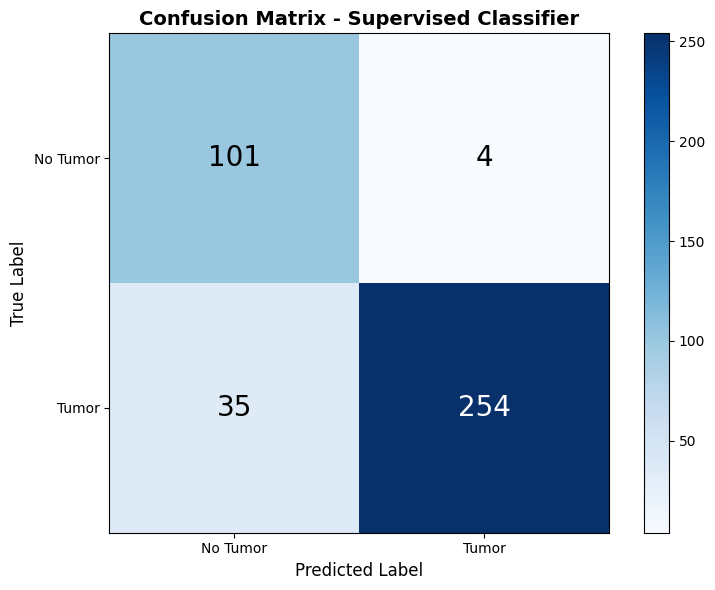

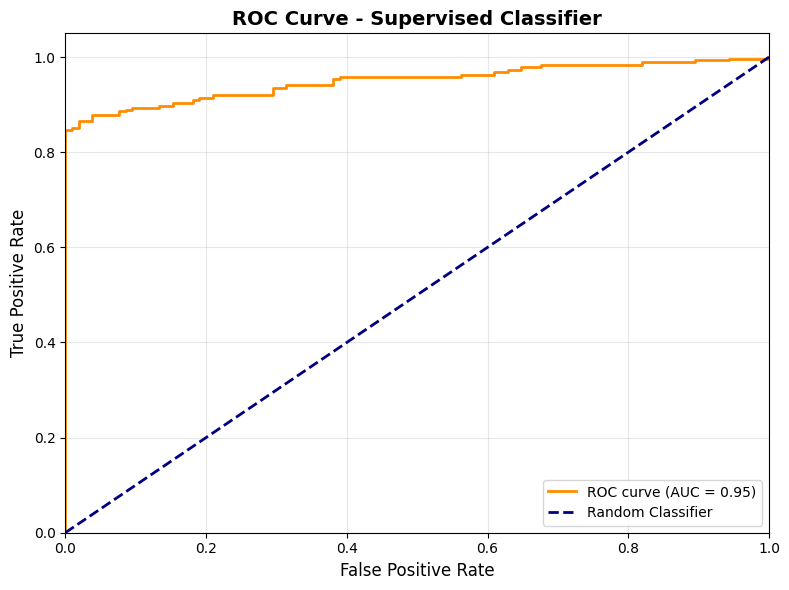


 AUC Score: 0.9496

SECTION 2: UNSUPERVISED ANOMALY DETECTION

 Autoencoder loaded successfully
 Using threshold: 0.048340

 Processing test images...
 Loaded 394 test images

 Reconstructing images...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step

ANOMALY DETECTION RESULTS
Threshold: 0.048340
Detected anomalies: 33 / 394
Detection rate: 8.38%

Anomalies in 'No Tumor' class: 5 / 105
Anomalies in 'Tumor' class: 28 / 289
Found 395 images belonging to 1 classes.

 Computing baseline errors on healthy training data...

THRESHOLD SENSITIVITY ANALYSIS

85th percentile (threshold = 0.041799):
  Tumor detection rate: 16.3% (47/289)
  False positive rate: 18.1% (19/105)

90th percentile (threshold = 0.046592):
  Tumor detection rate: 11.8% (34/289)
  False positive rate: 8.6% (9/105)

95th percentile (threshold = 0.051703):
  Tumor detection rate: 6.9% (20/289)
  False positive rate: 3.8% (4/105)

99th percentile (threshold = 0.065035):
  Tumor detection rate: 1.0% (3/289)
  False positive rate: 1.

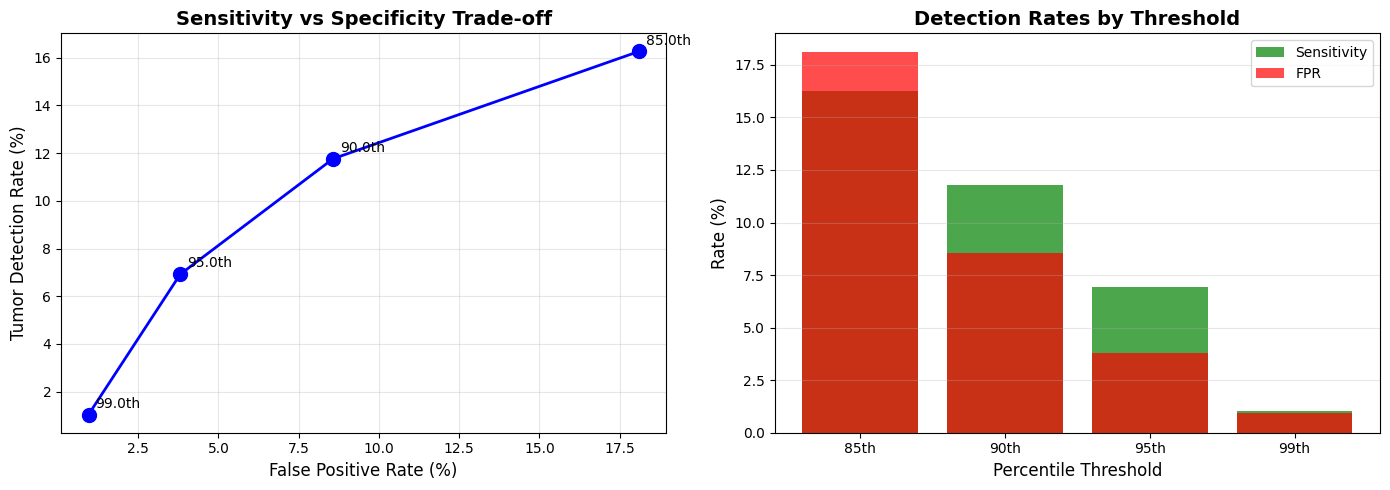


 Saving anomaly images to ../results/anomalies...
 Saved 33 anomaly images

💾 Results saved to: ../results/evaluation_results.csv


C:\Users\icho\AppData\Local\Temp\ipykernel_10504\3434127937.py:308: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors[no_tumor_mask], errors[tumor_mask]],


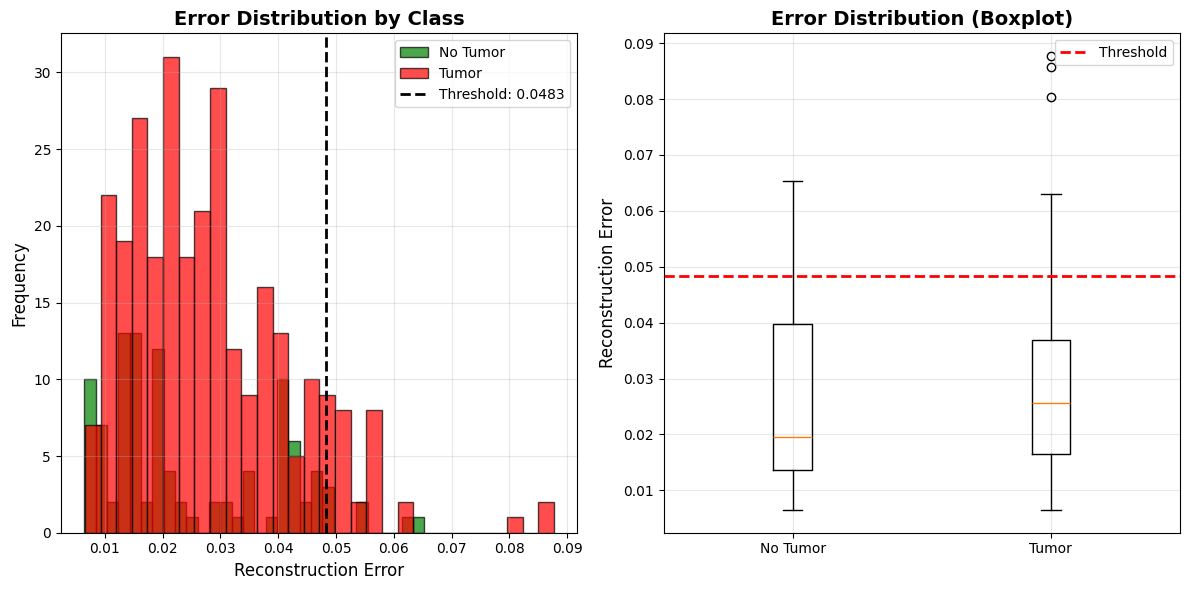


🔍 Visualizing example anomalies...


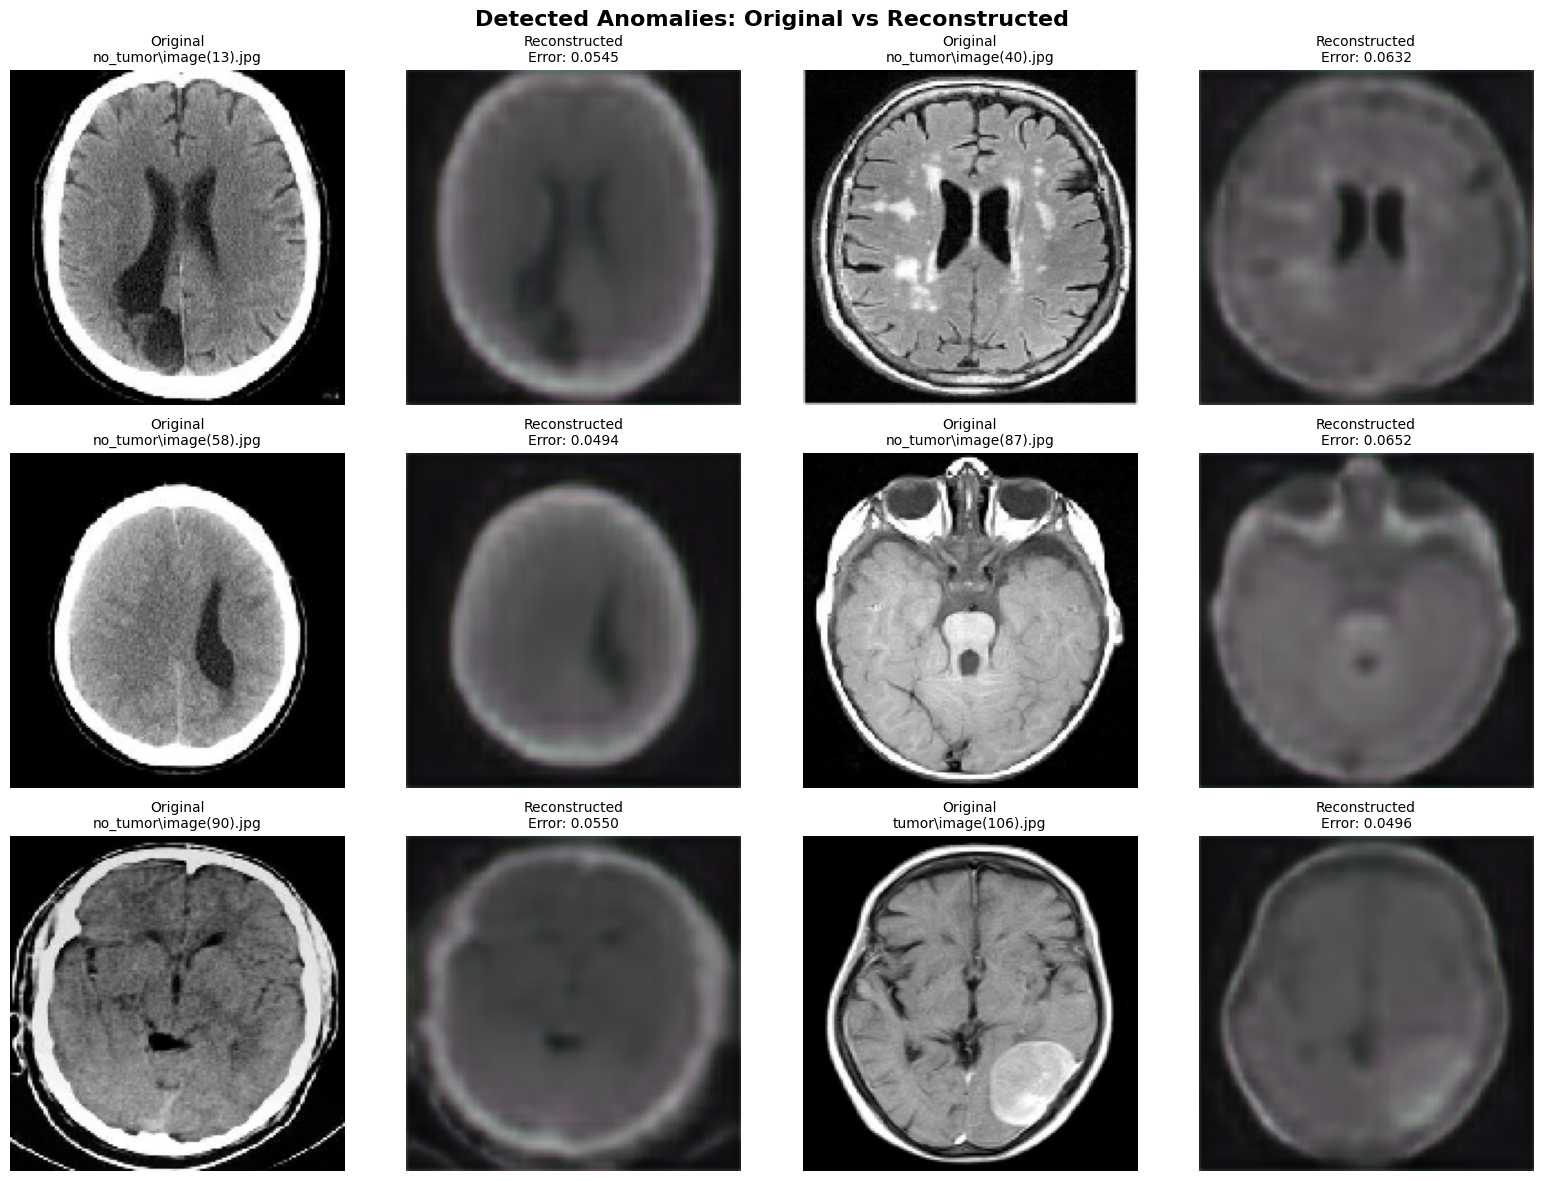


SECTION 3: COMPARISON OF METHODS

Cases where methods disagree: 243

Examples of disagreement:
    True Label Supervised Prediction Anomaly Detection  Reconstruction Error
0     No Tumor                 Tumor            Normal              0.035521
9     No Tumor              No Tumor           Anomaly              0.054512
20    No Tumor                 Tumor            Normal              0.009875
39    No Tumor              No Tumor           Anomaly              0.063183
58    No Tumor              No Tumor           Anomaly              0.049415
90    No Tumor              No Tumor           Anomaly              0.065250
94    No Tumor              No Tumor           Anomaly              0.054953
96    No Tumor                 Tumor            Normal              0.021991
104   No Tumor                 Tumor            Normal              0.024989
105      Tumor                 Tumor            Normal              0.024046

Agreement rate: 38.32%


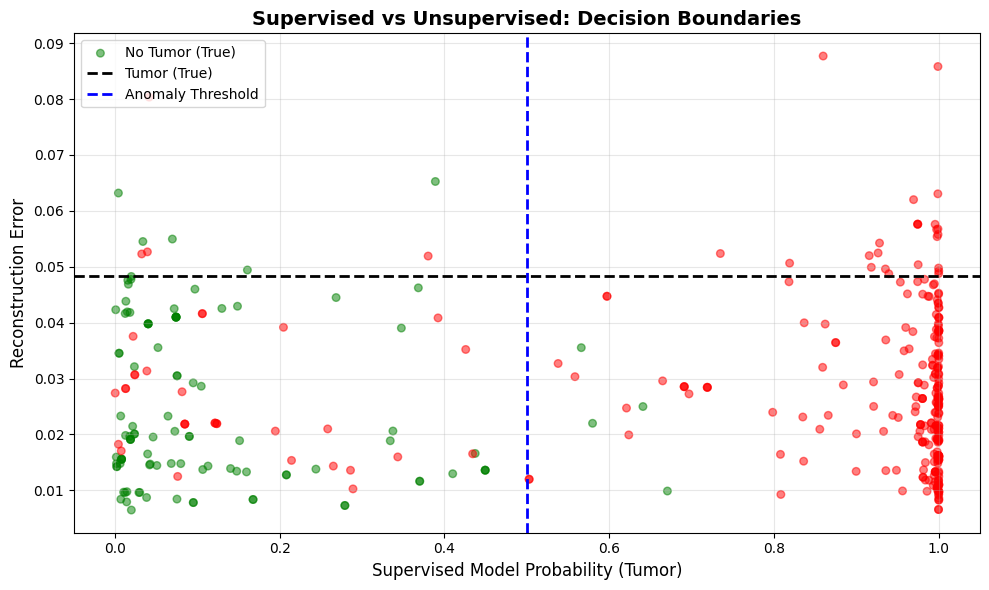


SECTION 4: ENSEMBLE METHOD - COMBINING BOTH MODELS

 MODEL COMPARISON:
Supervised Model (VGG16):        0.9010 (90.10%)
Unsupervised (Autoencoder):      0.3249 (32.49%)
Ensemble (OR voting):            0.8985 (89.85%)
Ensemble (AND voting):           0.3274 (32.74%)
Ensemble (Weighted 70/30):       0.8934 (89.34%)

📈 DETAILED METRICS - ENSEMBLE (Weighted):
              precision    recall  f1-score   support

    No Tumor       0.72      0.98      0.83       105
       Tumor       0.99      0.86      0.92       289

    accuracy                           0.89       394
   macro avg       0.86      0.92      0.88       394
weighted avg       0.92      0.89      0.90       394



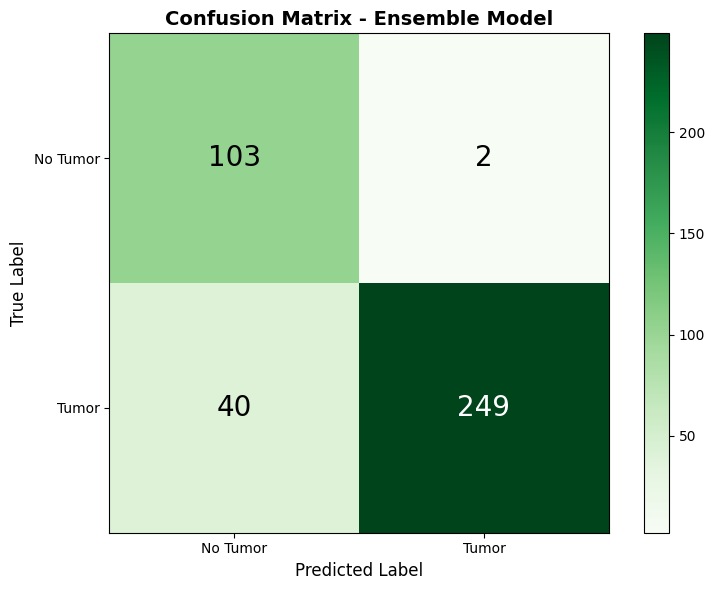

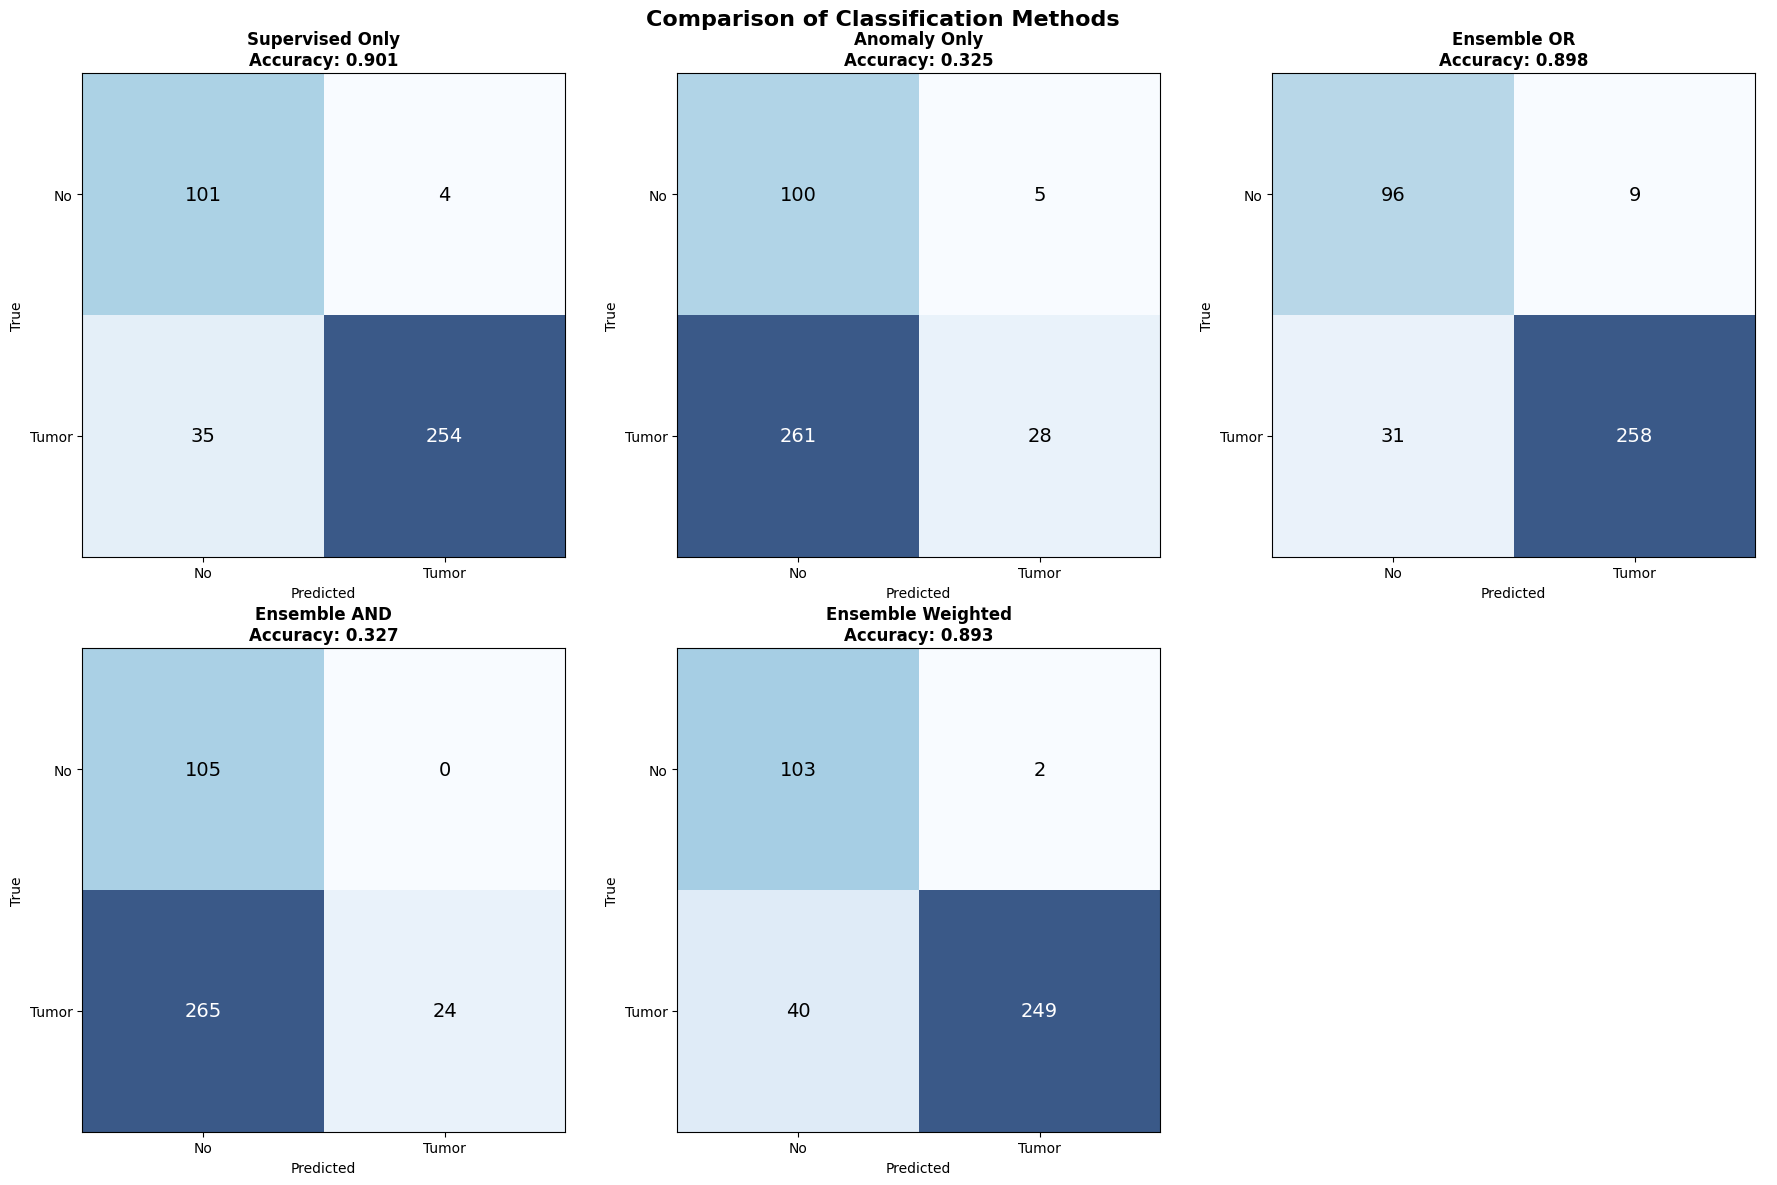

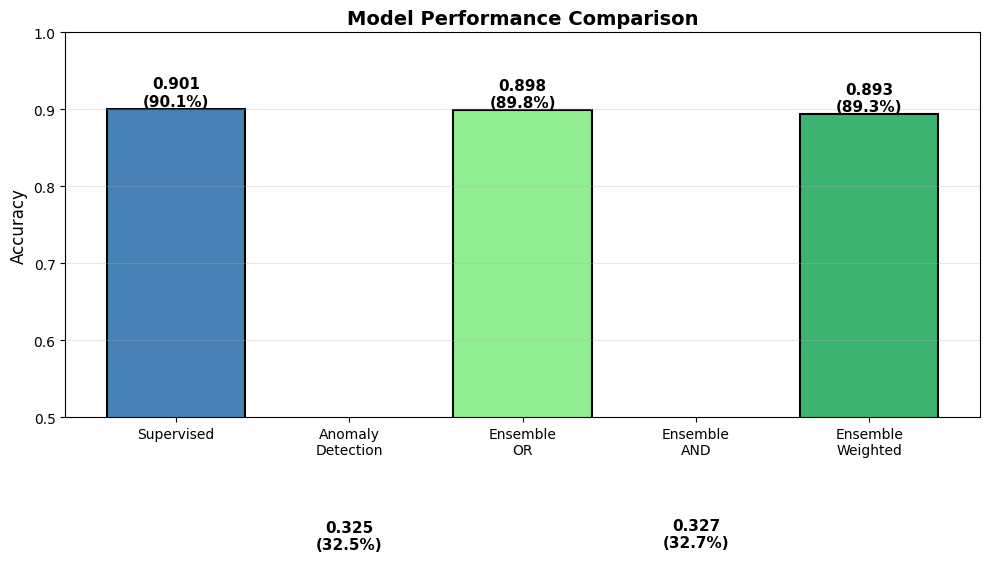


💡 ENSEMBLE STRATEGY ANALYSIS:
• OR Voting: Best for RECALL (catch all tumors)
  → Use when missing a tumor is dangerous
  → Accuracy: 89.8%

• AND Voting: Best for PRECISION (fewer false alarms)
  → Use when false positives are costly
  → Accuracy: 32.7%

• Weighted Voting: BALANCED approach
  → Best overall performance
  → Accuracy: 89.3%

 Ensemble results saved to: ../results/ensemble_results.csv

 EVALUATION COMPLETE!

Generated files:
   supervised_confusion_matrix.png
   supervised_roc_curve.png
   threshold_sensitivity_analysis.png (NEW!)
   error_distribution_comparison.png
   anomaly_examples.png
   methods_comparison.png
   evaluation_results.csv
   33 anomaly images in ../results/anomalies

 Project complete!


In [1]:
# ============================================
# BRAIN TUMOR CLASSIFICATION & ANOMALY DETECTION
# 03_evaluation.ipynb
# ============================================

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# ============================================
# SECTION 1: EVALUATE SUPERVISED CLASSIFIER
# ============================================

print("=" * 60)
print("SECTION 1: SUPERVISED MODEL EVALUATION")
print("=" * 60)

# Load test data
test_dir = "../data/Testing"
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(f"\n Test samples: {test_data.samples}")
print(f" Classes: {test_data.class_indices}")

# Load supervised model
supervised_model = tf.keras.models.load_model("../models/tumor_classifier_vgg16.keras")
print("\n Supervised model loaded successfully")

# Predict on test set
print("\n🔍 Making predictions...")
predictions = supervised_model.predict(test_data, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_data.classes

# Classification Report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(true_classes, predicted_classes, 
                          target_names=['No Tumor', 'Tumor']))


# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Supervised Classifier', fontsize=14, fontweight='bold')
plt.colorbar()

# Add numbers to cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', 
                color='white' if cm[i, j] > cm.max() / 2 else 'black', fontsize=20)

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks([0, 1], ['No Tumor', 'Tumor'])
plt.yticks([0, 1], ['No Tumor', 'Tumor'])
plt.tight_layout()
plt.savefig('../models/supervised_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


# ROC Curve
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Supervised Classifier', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../models/supervised_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n AUC Score: {roc_auc:.4f}")

# ============================================
# SECTION 2: ANOMALY DETECTION WITH AUTOENCODER
# ============================================

print("\n" + "=" * 60)
print("SECTION 2: UNSUPERVISED ANOMALY DETECTION")
print("=" * 60)

# Load autoencoder and threshold
autoencoder = tf.keras.models.load_model("../models/autoencoder_abnormality.keras")
threshold = np.load('../models/anomaly_threshold.npy')

print(f"\n Autoencoder loaded successfully")
print(f" Using threshold: {threshold:.6f}")

# Reload test data for autoencoder
test_data.reset()
all_images = []
all_labels = []
filenames = test_data.filenames

print("\n Processing test images...")
for i in range(len(test_data)):
    imgs, lbls = next(test_data)
    all_images.append(imgs)
    all_labels.append(lbls)

all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

print(f" Loaded {len(all_images)} test images")

# Reconstruct images
print("\n Reconstructing images...")
reconstructed = autoencoder.predict(all_images, verbose=1)

# Compute reconstruction errors
errors = np.mean(np.square(all_images - reconstructed), axis=(1, 2, 3))

# Detect anomalies
anomalies = errors > threshold

# Statistics
print("\n" + "=" * 60)
print("ANOMALY DETECTION RESULTS")
print("=" * 60)
print(f"Threshold: {threshold:.6f}")
print(f"Detected anomalies: {np.sum(anomalies)} / {len(errors)}")
print(f"Detection rate: {100 * np.sum(anomalies) / len(errors):.2f}%")

# Breakdown by true class
no_tumor_mask = all_labels == 0
tumor_mask = all_labels == 1

anomalies_in_healthy = np.sum(anomalies[no_tumor_mask])
anomalies_in_tumor = np.sum(anomalies[tumor_mask])

print(f"\nAnomalies in 'No Tumor' class: {anomalies_in_healthy} / {np.sum(no_tumor_mask)}")
print(f"Anomalies in 'Tumor' class: {anomalies_in_tumor} / {np.sum(tumor_mask)}")

# ============================================
# THRESHOLD SENSITIVITY ANALYSIS
# ============================================

# Load training data to compute baseline errors
train_dir = "../data/Training"
train_datagen = ImageDataGenerator(rescale=1./255)

train_data_healthy = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='input',
    classes=['no_tumor'],
    shuffle=False
)

print("\n Computing baseline errors on healthy training data...")
train_images_healthy = []
for i in range(len(train_data_healthy)):
    batch, _ = next(train_data_healthy)
    train_images_healthy.append(batch)
train_images_healthy = np.concatenate(train_images_healthy)

reconstructed_healthy = autoencoder.predict(train_images_healthy, verbose=0)
errors_healthy = np.mean(np.square(train_images_healthy - reconstructed_healthy), axis=(1, 2, 3))

# THRESHOLD SENSITIVITY ANALYSIS
print("\n" + "=" * 60)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("=" * 60)

# Test different percentile thresholds
percentiles = [85, 90, 95, 99]
results = []

for p in percentiles:
    thresh = np.percentile(errors_healthy, p)
    anomalies_detected = errors > thresh
    
    # Calculate metrics 
    tumor_detected = np.sum(anomalies_detected[tumor_mask])
    tumor_total = np.sum(tumor_mask)
    healthy_flagged = np.sum(anomalies_detected[no_tumor_mask])
    healthy_total = np.sum(no_tumor_mask)

    sensitivity = 100 * tumor_detected / tumor_total 
    fpr = 100 * healthy_flagged / healthy_total

    results.append({
        'percentile': p,
        'threshold': thresh,
        'sensitivity': sensitivity,
        'false_positive_rate': fpr,
        'tumors_detected': tumor_detected,
        'total_tumors': tumor_total
    })
    
    print(f"\n{p}th percentile (threshold = {thresh:.6f}):")
    print(f"  Tumor detection rate: {sensitivity:.1f}% ({tumor_detected}/{tumor_total})")
    print(f"  False positive rate: {fpr:.1f}% ({healthy_flagged}/{healthy_total})")

# Visualize trade-off
df_threshold_results = pd.DataFrame(results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sensitivity vs FPR
ax1.plot(df_threshold_results['false_positive_rate'], df_threshold_results['sensitivity'], 
         'o-', linewidth=2, markersize=10, color='blue')
for i, row in df_threshold_results.iterrows():
    ax1.annotate(f"{row['percentile']}th", 
                (row['false_positive_rate'], row['sensitivity']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)
ax1.set_xlabel('False Positive Rate (%)', fontsize=12)
ax1.set_ylabel('Tumor Detection Rate (%)', fontsize=12)
ax1.set_title('Sensitivity vs Specificity Trade-off', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Thresholds
ax2.bar(df_threshold_results['percentile'].astype(str) + 'th', 
        df_threshold_results['sensitivity'], alpha=0.7, label='Sensitivity', color='green')
ax2.bar(df_threshold_results['percentile'].astype(str) + 'th', 
        df_threshold_results['false_positive_rate'], alpha=0.7, label='FPR', color='red')
ax2.set_xlabel('Percentile Threshold', fontsize=12)
ax2.set_ylabel('Rate (%)', fontsize=12)
ax2.set_title('Detection Rates by Threshold', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/threshold_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# CONTINUE WITH ANOMALY IMAGE SAVING
# ============================================

# Create output directory
output_dir = "../results/anomalies"
os.makedirs(output_dir, exist_ok=True)

# Save anomaly images
print(f"\n Saving anomaly images to {output_dir}...")
saved_count = 0
for i, is_anomaly in enumerate(anomalies):
    if is_anomaly:
        img = (all_images[i] * 255).astype(np.uint8)
        img_pil = Image.fromarray(img)
        if img_pil.mode != "RGB":
            img_pil = img_pil.convert('RGB')

        base_name = os.path.basename(filenames[i])
        name_without_ext = base_name.rsplit('.', 1)[0].replace('.', '_')
        filename = f"{name_without_ext}_error_{errors[i]:.4f}.png"
        
        img_pil.save(os.path.join(output_dir, filename))
        saved_count += 1

print(f" Saved {saved_count} anomaly images")

# Save detailed results to CSV
records = []
for i in range(len(all_images)):
    records.append({
        "filename": filenames[i],
        "true_label": "tumor" if all_labels[i] == 1 else "no_tumor",
        "reconstruction_error": errors[i],
        "is_anomaly": bool(anomalies[i]),
        "supervised_prediction": "tumor" if predicted_classes[i] == 1 else "no_tumor"
    })

df_results = pd.DataFrame(records)
df_results.to_csv('../results/evaluation_results.csv', index=False)
print(f"\n💾 Results saved to: ../results/evaluation_results.csv")

# Visualize reconstruction errors by class
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(errors[no_tumor_mask], bins=30, alpha=0.7, label='No Tumor', color='green', edgecolor='black')
plt.hist(errors[tumor_mask], bins=30, alpha=0.7, label='Tumor', color='red', edgecolor='black')
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
plt.xlabel('Reconstruction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Error Distribution by Class', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([errors[no_tumor_mask], errors[tumor_mask]], 
            labels=['No Tumor', 'Tumor'])
plt.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold')
plt.ylabel('Reconstruction Error', fontsize=12)
plt.title('Error Distribution (Boxplot)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/error_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize example anomalies
print("\n🔍 Visualizing example anomalies...")
anomaly_indices = np.where(anomalies)[0][:6]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx, i in enumerate(anomaly_indices):
    row = idx // 2
    col_offset = (idx % 2) * 2
    
    # Original
    axes[row, col_offset].imshow(all_images[i])
    axes[row, col_offset].set_title(f'Original\n{filenames[i].split("/")[0]}', fontsize=10)
    axes[row, col_offset].axis('off')
    
    # Reconstructed
    axes[row, col_offset + 1].imshow(reconstructed[i])
    axes[row, col_offset + 1].set_title(f'Reconstructed\nError: {errors[i]:.4f}', fontsize=10)
    axes[row, col_offset + 1].axis('off')

plt.suptitle('Detected Anomalies: Original vs Reconstructed', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/anomaly_examples.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# SECTION 3: COMPARE SUPERVISED VS UNSUPERVISED
# ============================================

print("\n" + "=" * 60)
print("SECTION 3: COMPARISON OF METHODS")
print("=" * 60)

# Create comparison dataframe
comparison = pd.DataFrame({
    'True Label': ['No Tumor' if x == 0 else 'Tumor' for x in all_labels],
    'Supervised Prediction': ['No Tumor' if x == 0 else 'Tumor' for x in predicted_classes],
    'Anomaly Detection': ['Normal' if not x else 'Anomaly' for x in anomalies],
    'Reconstruction Error': errors
})

# Cases where methods disagree
disagreement = (predicted_classes == 0) & (anomalies == True) | \
               (predicted_classes == 1) & (anomalies == False)

print(f"\nCases where methods disagree: {np.sum(disagreement)}")
print("\nExamples of disagreement:")
print(comparison[disagreement].head(10))

# Agreement analysis
agreement = (predicted_classes == 1) & (anomalies == True) | \
            (predicted_classes == 0) & (anomalies == False)

print(f"\nAgreement rate: {100 * np.sum(agreement) / len(all_labels):.2f}%")

# Visualization: Scatter plot
plt.figure(figsize=(10, 6))
colors = ['green' if x == 0 else 'red' for x in all_labels]
plt.scatter(predictions.flatten(), errors, c=colors, alpha=0.5, s=30)
plt.axhline(threshold, color='black', linestyle='--', linewidth=2, label='Anomaly Threshold')
plt.axvline(0.5, color='blue', linestyle='--', linewidth=2, label='Classification Threshold')
plt.xlabel('Supervised Model Probability (Tumor)', fontsize=12)
plt.ylabel('Reconstruction Error', fontsize=12)
plt.title('Supervised vs Unsupervised: Decision Boundaries', fontsize=14, fontweight='bold')
plt.legend(['No Tumor (True)', 'Tumor (True)', 'Anomaly Threshold', 'Classification Threshold'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================
# SECTION 4: ENSEMBLE VOTING (CHAPTER 7)
# ============================================

print("\n" + "=" * 60)
print("SECTION 4: ENSEMBLE METHOD - COMBINING BOTH MODELS")
print("=" * 60)

# Strategy 1: OR Voting (tumor if EITHER model detects it)
ensemble_or = (predicted_classes == 1) | (anomalies == True)

# Strategy 2: AND Voting (tumor only if BOTH models agree)
ensemble_and = (predicted_classes == 1) & (anomalies == True)

# Strategy 3: Weighted Voting (supervised får mere vægt)
# Normalize anomaly scores to 0-1 range
supervised_scores = predictions.flatten()  # Already 0-1
anomaly_scores = (errors - errors.min()) / (errors.max() - errors.min())

# Weighted average (70% supervised, 30% anomaly)
ensemble_weighted = 0.7 * supervised_scores + 0.3 * anomaly_scores
ensemble_weighted_pred = (ensemble_weighted > 0.5).astype(int)

# Calculate accuracies
acc_supervised = np.mean(predicted_classes == true_classes)
acc_anomaly = np.mean(anomalies.astype(int) == true_classes)
acc_or = np.mean(ensemble_or.astype(int) == true_classes)
acc_and = np.mean(ensemble_and.astype(int) == true_classes)
acc_weighted = np.mean(ensemble_weighted_pred == true_classes)

print("\n MODEL COMPARISON:")
print("=" * 60)
print(f"Supervised Model (VGG16):        {acc_supervised:.4f} ({acc_supervised*100:.2f}%)")
print(f"Unsupervised (Autoencoder):      {acc_anomaly:.4f} ({acc_anomaly*100:.2f}%)")
print(f"Ensemble (OR voting):            {acc_or:.4f} ({acc_or*100:.2f}%)")
print(f"Ensemble (AND voting):           {acc_and:.4f} ({acc_and*100:.2f}%)")
print(f"Ensemble (Weighted 70/30):       {acc_weighted:.4f} ({acc_weighted*100:.2f}%)")

# Detailed metrics for best ensemble
best_ensemble = ensemble_weighted_pred
print("\n📈 DETAILED METRICS - ENSEMBLE (Weighted):")
print("=" * 60)
print(classification_report(true_classes, best_ensemble, 
                          target_names=['No Tumor', 'Tumor']))

# Confusion Matrix for Ensemble
cm_ensemble = confusion_matrix(true_classes, best_ensemble)
plt.figure(figsize=(8, 6))
plt.imshow(cm_ensemble, interpolation='nearest', cmap='Greens')
plt.title('Confusion Matrix - Ensemble Model', fontsize=14, fontweight='bold')
plt.colorbar()

for i in range(cm_ensemble.shape[0]):
    for j in range(cm_ensemble.shape[1]):
        plt.text(j, i, str(cm_ensemble[i, j]), ha='center', va='center', 
                color='white' if cm_ensemble[i, j] > cm_ensemble.max() / 2 else 'black', 
                fontsize=20)

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks([0, 1], ['No Tumor', 'Tumor'])
plt.yticks([0, 1], ['No Tumor', 'Tumor'])
plt.tight_layout()
plt.savefig('../results/ensemble_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization: Compare all methods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

methods = [
    ('Supervised Only', predicted_classes, acc_supervised),
    ('Anomaly Only', anomalies.astype(int), acc_anomaly),
    ('Ensemble OR', ensemble_or.astype(int), acc_or),
    ('Ensemble AND', ensemble_and.astype(int), acc_and),
    ('Ensemble Weighted', ensemble_weighted_pred, acc_weighted)
]

for idx, (name, preds, acc) in enumerate(methods):
    row = idx // 3
    col = idx % 3
    
    cm = confusion_matrix(true_classes, preds)
    
    axes[row, col].imshow(cm, interpolation='nearest', cmap='Blues', alpha=0.8)
    axes[row, col].set_title(f'{name}\nAccuracy: {acc:.3f}', 
                            fontsize=12, fontweight='bold')
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[row, col].text(j, i, str(cm[i, j]), 
                              ha='center', va='center', 
                              color='white' if cm[i, j] > cm.max() / 2 else 'black',
                              fontsize=14)
    
    axes[row, col].set_ylabel('True')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_xticks([0, 1])
    axes[row, col].set_yticks([0, 1])
    axes[row, col].set_xticklabels(['No', 'Tumor'])
    axes[row, col].set_yticklabels(['No', 'Tumor'])

# Hide the last subplot
axes[1, 2].axis('off')

plt.suptitle('Comparison of Classification Methods', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/all_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Bar chart comparison
plt.figure(figsize=(10, 6))
method_names = ['Supervised', 'Anomaly\nDetection', 'Ensemble\nOR', 
                'Ensemble\nAND', 'Ensemble\nWeighted']
accuracies = [acc_supervised, acc_anomaly, acc_or, acc_and, acc_weighted]

colors = ['steelblue', 'coral', 'lightgreen', 'gold', 'mediumseagreen']
bars = plt.bar(method_names, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}\n({acc*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim([0.5, 1.0])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../results/accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis: Which method is best for which scenario?
print("\n💡 ENSEMBLE STRATEGY ANALYSIS:")
print("=" * 60)
print(f"• OR Voting: Best for RECALL (catch all tumors)")
print(f"  → Use when missing a tumor is dangerous")
print(f"  → Accuracy: {acc_or*100:.1f}%")
print(f"\n• AND Voting: Best for PRECISION (fewer false alarms)")
print(f"  → Use when false positives are costly")
print(f"  → Accuracy: {acc_and*100:.1f}%")
print(f"\n• Weighted Voting: BALANCED approach")
print(f"  → Best overall performance")
print(f"  → Accuracy: {acc_weighted*100:.1f}%")

# Save ensemble results
df_ensemble = pd.DataFrame({
    'filename': filenames,
    'true_label': ['tumor' if x == 1 else 'no_tumor' for x in true_classes],
    'supervised_pred': ['tumor' if x == 1 else 'no_tumor' for x in predicted_classes],
    'anomaly_detected': anomalies,
    'ensemble_or': ensemble_or,
    'ensemble_and': ensemble_and,
    'ensemble_weighted': ensemble_weighted_pred,
    'supervised_prob': predictions.flatten(),
    'anomaly_score': errors
})

df_ensemble.to_csv('../results/ensemble_results.csv', index=False)
print(f"\n Ensemble results saved to: ../results/ensemble_results.csv")


# Final summary
print("\n" + "=" * 60)
print(" EVALUATION COMPLETE!")
print("=" * 60)
print("\nGenerated files:")
print("   supervised_confusion_matrix.png")
print("   supervised_roc_curve.png")
print("   threshold_sensitivity_analysis.png (NEW!)")
print("   error_distribution_comparison.png")
print("   anomaly_examples.png")
print("   methods_comparison.png")
print("   evaluation_results.csv")
print(f"   {saved_count} anomaly images in {output_dir}")
print("\n Project complete!")




In [2]:
import sys
!{sys.executable} -m pip install seaborn